In [1]:
import sys
import scri
import sxs
import numpy as np
import quaternion
from quaternion import rotate_vectors
from matplotlib import pyplot as plt
from scri import flux
import functools
from scri import waveform_base
from scipy.integrate import trapz as integrate
from scipy.optimize import curve_fit
from scri import WaveformModes

SA_path="/home/khushal/Desktop/Python/SXS data/SXS:BBH:0126/"
Waveform_path="rhOverM_Asymptotic_GeometricUnits_CoM.h5/Extrapolated_N4.dir"
md = sxs.metadata.Metadata.from_file(SA_path + "metadata.txt")    
h = scri.SpEC.read_from_h5(SA_path +  Waveform_path)
M = md['remnant_mass']

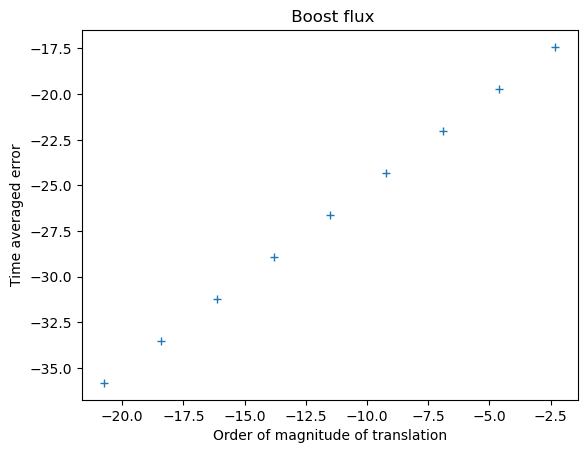

In [3]:
t = 1.0
x = []
errors = []

           
for β in range(1,10):
    x.append(10**(-β))
    hp = h.transform(time_translation=10**(-β)*t)
    w1 = scri.boost_flux(hp)
    w2 = scri.boost_flux(h)
    error = np.linalg.norm((w1 - w2),axis = 1)
    errors.append(np.abs(integrate(error, hp.t)) / (hp.t[-1] - hp.t[0]))
    
plt.xlabel("Order of magnitude of translation")
plt.ylabel("Time averaged error")
plt.title(" Boost flux")
plt.plot(np.log(np.transpose(x)),np.log(errors),'+')
plt.show()

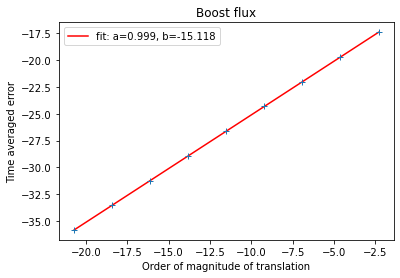

In [79]:
t = 1.0
x = []
errors = []
             
for β in range(1,10):
    x.append(10**(-β))
    hp = h.transform(time_translation=10**(-β)*t)
    w1 = scri.boost_flux(hp)
    w2 = scri.boost_flux(h) 
    error = np.linalg.norm((w1 - w2),axis = 1)
    errors.append(np.abs(integrate(error, hp.t)) / (hp.t[-1] - hp.t[0]))
        
def func(x, a, b):
    return a * x + b    
    
xdata = np.log(np.transpose(x) )  
ydata = np.log(errors)    
popt, pcov = curve_fit(func, xdata, ydata)    
plt.xlabel("Order of magnitude of translation")
plt.ylabel("Time averaged error")
plt.title("Boost flux")
plt.plot(xdata, func(xdata, *popt),'r-',label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.plot(xdata,ydata,'+')
plt.legend()
plt.show()

The plot is between log(error) and log(order of mag)

$$ log(err) = a log(mag) + b $$

$$ err = e^b mag^a $$ 

$$ err = 10^{-7} mag^{0.999} $$

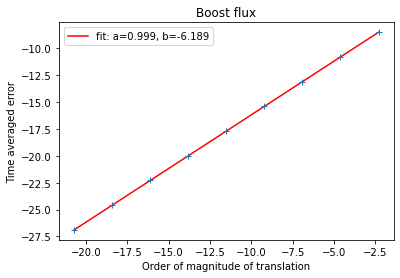

In [60]:
t = 1.0
x = []
errors = []
s = np.array([1.0, 8.0, 5.0] )

for β in range(1,10):
    x.append(10**(-β))
    hp = h.transform(space_translation=10**(-β)*s)
    w1 = scri.boost_flux(hp)
    w2 = scri.boost_flux(h.interpolate(hp.t))
    error = np.linalg.norm((w1 - w2),axis = 1)
    errors.append(np.abs(integrate(error, hp.t)) / (hp.t[-1] - hp.t[0]))
        
def func(x, a, b):
    return a * x + b    
    
xdata = np.log(np.transpose(x) )  
ydata = np.log(errors)    
popt, pcov = curve_fit(func, xdata, ydata)    
plt.xlabel("Order of magnitude of translation")
plt.ylabel("Time averaged error")
plt.title("Boost flux")
plt.plot(xdata, func(xdata, *popt),'r-',label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.plot(xdata, ydata,'+')
plt.legend()
plt.show()

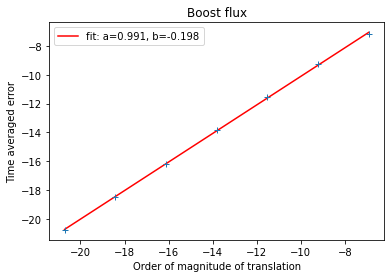

In [73]:
x = []
errors = []
s = np.array([1.0,0.0,0.0])

def lorentz_transformation(v, w, t,M):
    beta = np.linalg.norm(v)
    g_m = (1/(1 - beta**2))**(1/2)
    Boost_matrix = [[g_m ,  g_m * beta, 0,0], [ g_m * beta, g_m, 0, 0], [0,0,1,0],[0,0,0,1]]    
    for j in range(3):
        M[0,j+1,:] = w[:,j]
        M[j+1,0,:] = M[0,j+1,:]
    M = np.einsum('mi,ilk->mlk', Boost_matrix, np.einsum('ijk, jl -> ilk', M, Boost_matrix)) 
    return M

for β in range(3,10):
    x.append(10**(-β))
    v = 10**(-β)*s    
    hp = h.transform(boost_velocity=v)
    t = len(hp.t)    
    w1 = scri.boost_flux(hp)
    w2 = scri.boost_flux(h.interpolate(hp.t))
    M = np.zeros((4,4,t))
    B_M = lorentz_transformation(v, w2, t, M)
    w2 = np.c_[B_M[0,1,:],B_M[0,2,:],B_M[0,3,:]]
    error = np.linalg.norm((w1 - w2),axis = 1)
    errors.append(np.abs(integrate(error, hp.t)) / (hp.t[-1] - hp.t[0]))

        
def func(x, a, b):
    return a * x + b    
    
xdata = np.log(np.transpose(x) )  
ydata = np.log(errors)    
popt, pcov = curve_fit(func, xdata, ydata)    
plt.xlabel("Order of magnitude of translation")
plt.ylabel("Time averaged error")
plt.title("Boost flux")
plt.plot(xdata, func(xdata, *popt),'r-',label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.plot(xdata,ydata,'+')
plt.legend()
plt.show()

In [3]:
import scri

In [4]:
w = scri.WaveformModes()

AttributeError: module 'scri' has no attribute 'WaveformModes'

In [ ]:
errors = []
for β in [0.1, 0.01, 0.001, 0.0001]:
    v = [β,0.0,0.0]
    beta = np.linalg.norm(v)
    g_m = (1/(1 - beta**2))**(1/2)
    hp = h.transform(boost_velocity=v)
    B_dotp = scri.boost_flux(hp)
    Boost_matrix = [[g_m ,  g_m * beta, 0,0], [ g_m * beta, g_m, 0, 0], [0,0,1,0],[0,0,0,1]]
    B_dot = scri.boost_flux(h.interpolate(hp.t)) 
    for i in range(len(hp.t)):
        Bondi_p_dot[i,:] = np.transpose(np.dot(Boost_matrix, np.transpose(Bondi_p_dot[i,:])))   
    error = w1 - w2
    errors.append(np.abs(integrate(error, h.t)) / (h.t[-1] - h.t[0]))
plt.loglog([0.1, 0.01, 0.001, 0.0001],errors,'+')
plt.show()

In [ ]:
plt.plot(h.t, scri.boost_flux(h)[:,0])